# Lab ML for DS SS23
## Project 3
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [ ]:
# TODO: implementation: do we change the model each time??
# TODO: implementation: square the sensitivity scores and adapt the heatmap
# TODO show predicted classes when displaying the saliency maps

In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import copy
import glob
import random

%matplotlib inline

/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <8CBD0B78-6C7C-3C8B-8C76-ACA7B6112818> /Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <07CB8E54-8386-3606-A01E-B92223F93B74> /Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


# 1. The Dataset

#### Choose to use google colab or run locally

In [7]:
COLAB = True

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r"/content/drive/My Drive/data/"
    N_SAMPLES = 100
else:
    DATA_PATH = r"./images/"
    N_SAMPLES = 10

#### Load sample of healthy and diseased plants

In [8]:
random.seed(7)
torch.manual_seed(7)

# don't use DataLoader and ImageFolder here, since we only need the N_SAMPLES per class
filelist = [
    *random.sample(glob.glob(DATA_PATH + "/Apple___healthy/*.JPG"), N_SAMPLES),
    *random.sample(glob.glob(DATA_PATH + "/Apple___Black_rot/*.JPG"), N_SAMPLES),
]

# load all images in filelist into tensor
X = torch.stack([transforms.ToTensor()(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)) for fname in filelist])
# X = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X) # normalize on vgg16 data
y = torch.tensor([0] * N_SAMPLES + [1] * N_SAMPLES)

#### Plot some example images for both classes

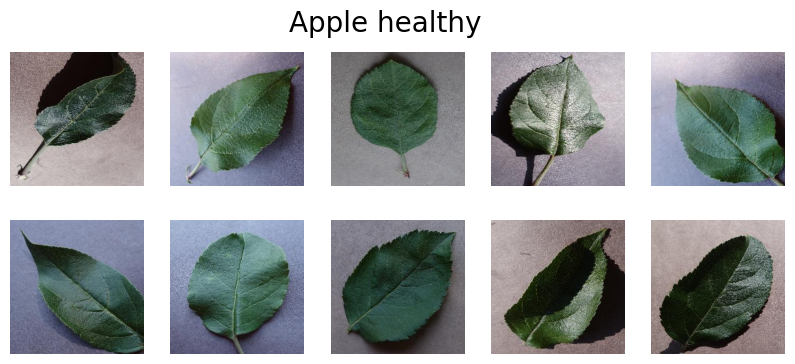

<Figure size 640x480 with 0 Axes>

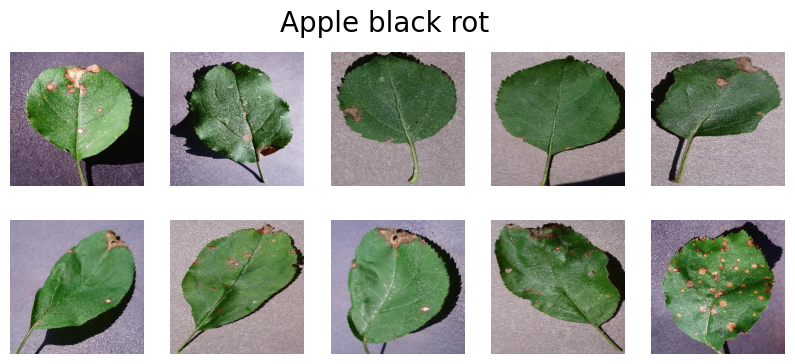

<Figure size 640x480 with 0 Axes>

In [10]:
# plot some images in a grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle(title, fontsize=20)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()
    plt.tight_layout()

plot_images(X[y == 0], "Apple healthy")
plot_images(X[y == 1], "Apple black rot")

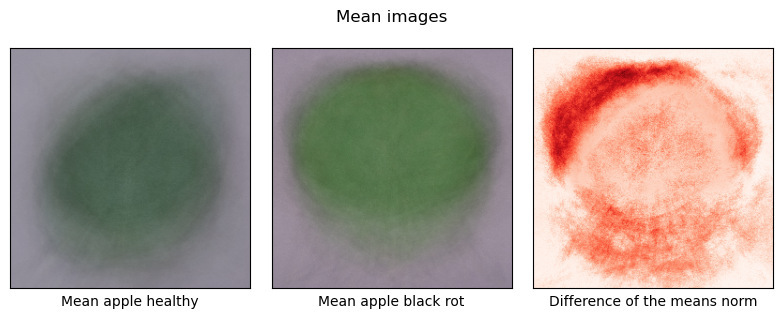

In [11]:
# Visualise mean images
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
mean0 = torch.mean(X[y == 0].permute(0, 2, 3, 1), dim=0)
mean1 = torch.mean(X[y == 1].permute(0, 2, 3, 1), dim=0)
diff = mean0 - mean1
#diff = torch.abs(diff) # Absolute difference of the means
diff = diff.norm(dim=2) # TODO square and adapt the min/max here too?

axs[0].imshow(mean0)
axs[1].imshow(mean1)
axs[2].imshow(diff, cmap="Reds")

axs[0].set(xlabel="Mean apple healthy", xticks=[], yticks=[])
axs[1].set(xlabel="Mean apple black rot", xticks=[], yticks=[])
axs[2].set(xlabel="Difference of the means norm", xticks=[], yticks=[])
plt.suptitle("Mean images")
plt.tight_layout()

#### Observation:
The mean shape and colour of the leaves appear to differ in the two conditions. The difference in shape is not necessarily caused by the condition, therefore there might be a sampling bias. At the same time, the diseased leaves often have a deteriorated tip which might be what is reflected in the mean image and indeed be indicative of the disease.

We also calculated the pixel-wise difference of the means by subtracting the mean image of the healthy leaves ("control") from the mean image of the affected leaves. We then plotted the Euclidean norm of the difference across the colour channels. We see that the upper left part of the rim of the diseased leaves exhibits the highest difference, followed by the other parts of the leaf contour, followed by the central part of the leaves.

# 2. Pretrained Models for Image Recognition

#### Use features of vgg16 model

In [ ]:
model_features = nn.Sequential(
    *vgg16(weights=VGG16_Weights.DEFAULT).features,
    torch.nn.Flatten(start_dim=1)
)

model_features.to(device) # model = pointer, for tensors: copy on other device
model_features.eval()

# 3. Predicting Classes from Images

#### Split data into train and test, then run through the model to get feature representation.

In [ ]:
X = X.to(device)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
with torch.no_grad():
    X_train_features = model_features(X_train).to("cpu")
    X_test_features = model_features(X_test).to("cpu")
    torch.cuda.empty_cache()

print(X_train_features.shape)


#### Calculate mean feature representation per class to get the ‘difference-of-means’ discriminant.

In [ ]:
images_0_train = X_train_features[y_train == 0]
images_1_train = X_train_features[y_train == 1]
mean_0 = images_0_train.mean(dim=0)
mean_1 = images_1_train.mean(dim=0)
mean_difference = mean_1 - mean_0
w = mean_difference / mean_difference.norm()

print("Size of difference-of-means discriminant:", w.size())

# For standardizing purposes
X_train_mean = X_train.mean(dim=0)
X_train_std = X_train.std(dim=0)

#### Project data on the ‘difference-of-means’ discriminant using the dot product to score (new) instances.

In [ ]:
pred_scores_train = torch.matmul(X_train_features, w)
pred_scores_test = torch.matmul(X_test_features, w)

#### Evaluate performance of ‘difference-of-means’ discriminant on the test set

In [ ]:
print(f"AUC Score on the training set: {roc_auc_score(y_train, pred_scores_train)}, number of instances of each class = {torch.sum(y_train==0).cpu()}.")
print(f"AUC Score on the test set: {roc_auc_score(y_test, pred_scores_test)}, number of instances of each class = {torch.sum(y_test==0).cpu()}.\n")

# plot a roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred_scores_test, drop_intermediate=False)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (Positive label: Apple black rot)")
plt.ylabel("True Positive Rate (Positive label: Apple black rot)")
plt.title("ROC curve (test set)")
plt.show()

#### Observation:
We evaluated the discriminating ability of the "difference-of-means" for the two classes by plotting the Receiver Operating Characteristics (ROC) curve and computing the area under the curve (AUC) on the test set.

We made sure that our test set is balanced in regard to the number of instances from each class (20), since we split the data in a stratified fashion.

This resulted in an AUC score of 0.9925. As an aggregate measure of performance across all possible classification thresholds, it indicates a very good separability between the classes.

# 4. Understanding the Image-Class Relation Pixel-Wise

# 4.1 Sensitivity Analysis

#### Add a linear layer representing the projection on the mean difference vector.

In [ ]:
projection_layer = torch.nn.Linear(in_features=X_train_features.size()[1], out_features=1, bias=False)

# use w as the weights for the projection layer
projection_layer.weight = torch.nn.Parameter(w.to(device))

# add the projection layer to the model to get the different of means model
model_dom = model_features.append(projection_layer)

#### Pixel-wise explanation of the prediction for a given image:
- look at the derivative of the model w.r.t. the input pixel
- compute importance scores by computing (square) norm of gradient per pixel (over channels)
- render scores as heatmap

#### Compute an image-specific sensitivity map for the predicted class

In [ ]:
def get_sensitivity(model, input_data):
    output = model(input_data)
    output.backward()
    sensitivity = input_data.grad.norm(dim=1).to("cpu")  # TODO square norm?
    return sensitivity


def plot_sensitivity_map(sensitivity_fnc=get_sensitivity, test_set_id=25, model=model_dom):

    img = X_test[test_set_id].unsqueeze(0)  # on device

    input_data_standardized = (img - X_train_mean) / X_train_std

    # mean and std per channel from vgg16 training set
    input_data_standardized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)

    img.requires_grad = True
    input_data_standardized.requires_grad = True
    input_data_standardized_vgg16.requires_grad = True

    # get sensitivity
    sensitivity = sensitivity_fnc(model, img)
    sensitivity_norm = sensitivity_fnc(model, input_data_standardized)
    sensitivity_norm_vgg16 = sensitivity_fnc(model, input_data_standardized_vgg16)

    # plot to images
    fig, axs = plt.subplots(2, 3, figsize=(15, 12))

    axs[0, 0].imshow(torch.permute(img[0].detach().cpu(), (1, 2, 0)))
    axs[0, 1].imshow(torch.permute(input_data_standardized[0].detach().cpu(), (1, 2, 0)))
    axs[0, 2].imshow(torch.permute(input_data_standardized_vgg16[0].detach().cpu(), (1, 2, 0)))
    axs[1, 0].imshow(sensitivity.squeeze(0), cmap="Reds")
    axs[1, 1].imshow(sensitivity_norm.squeeze(0), cmap="Reds")
    axs[1, 2].imshow(sensitivity_norm_vgg16.squeeze(0), cmap="Reds")

    axs[0, 0].set_title("Unprocessed image")
    axs[0, 1].set_title("Normalized image on train data")
    axs[0, 2].set_title("Normalized image on VGG-16 data")
    axs[1, 0].set_title("Importance scores (using input above)")
    axs[1, 1].set_title("Importance scores (using input above)")
    axs[1, 2].set_title("Importance scores (using input above)")

    fig.suptitle(f"Sensitivity Analysis for Prediction, label: {y_test[test_set_id]}")
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()


plot_sensitivity_map(get_sensitivity, test_set_id=25, model=model_dom)

In [ ]:
# TODO maybe choose a different image?
# TODO show predicted class

#### Observation:
We can see that the pixels in the upper area of the leave tend to induce higher importance scores for the class prediction. However, the resulting sensitivity heatmaps are visually noisy. The per-color-channel normalisation of the input images seems to slightly reduce the noise, so does the normalisation based on the ImageNet data statistics. In the latter case, the contrast in the heatmap is slightly increased.

We expected the normalisation of the input to provide more stable and more uniform gradients, especially if we normalise based on the data set statistics. The good results using the ImageNet data statistics imply that the image domain, used to train the VGG-16 network, is similar to our data domain and can also be successfully used for normalisation.

We expect that Batch normalisation layers in the model would potentially induce a similar effect of increasing the stability of the gradients and thereby somewhat reducing the noise.


# 4.2 More Robust Explanations

#### Apply [SmoothGradient](https://doi.org/10.48550/arXiv.1706.03825) approach by adding Gaussian noise to the input and averaging out the importance scores

In [ ]:
def get_sensitivity_smooth_gradient(model, input_data, noise_std=0.1, n=20):
    """Add Gaussian noise to the input and calculate the importance scores n times.
    Return the average sensitivity map.
    Hyperparameters: noise_std, n."""
    sensitivity = 0
    for _ in range(n):
        model = copy.deepcopy(model) # TODO copy model? or copy data? is the model changed in each iteration???
        noise = torch.randn_like(input_data) * noise_std
        noisy_input = input_data + noise
        output = model(noisy_input.to(device))
        output.backward()
        sensitivity += input_data.grad.norm(dim=1).to("cpu")
    return sensitivity / n

plot_sensitivity_map(get_sensitivity_smooth_gradient, test_set_id=25, model=model_dom)

#### Observations:
Since using the raw gradient as a proxy for feature importance appears to be visually noisy, we attempted to tackle the issue by using the SmoothGradient approach. According to the authors, the noise in sensitivity maps might be caused by essentially meaningless local variations in partial derivatives. Therefore, we applied a Gaussian kernel with SD = 0.1 in order to generate 20 random samples in a neighborhood of the input image, and averaged the resulting sensitivity map. We tuned the hyperparameters unsystematically by visual inspection.

We can observe that this approach delivers a heatmap reminiscent of the shape of the leaf. As discussed earlier, the difference of leaves' shapes between the two classes might either be a result of a sampling bias or a true indicator of the disease. In both cases, the interpretation of the heatmap suggests that the shape of this particular leave and partially its surface are the main contributors to the prediction of the black rot.

#### Create a biased convolution layer

In [ ]:
class BiasedLayer(torch.nn.Module):
    def __init__(self, ConvLayer):
        super().__init__()
        self.biased_conv = copy.deepcopy(ConvLayer)
        self.og_conv = ConvLayer

        self.biased_conv.weight = torch.nn.Parameter(self.og_conv.weight + (0.25 * torch.clip(self.og_conv.weight, min=0)))
        self.biased_conv.bias = torch.nn.Parameter(self.og_conv.bias + (0.25 * torch.clip(self.og_conv.bias, min=0)))


    def forward(self, X):
        biased_out = self.biased_conv.forward(X)
        og_out = self.og_conv.forward(X)

        return biased_out * (og_out / biased_out).detach()

#### Test the biased layer with a tensor

In [ ]:
# create Conv2d layer
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)
conv.weight = torch.nn.Parameter(torch.tensor([[[[1., 1., 1.],
                                                        [1., 1., 1.],
                                                        [1., 1., 1.]]]]))
conv.bias = torch.nn.Parameter(torch.tensor([1.]))

# Convert it to BiasedLayer instance
biased_conv = BiasedLayer(conv)

# Create Artificial Input
test_input_data = torch.tensor([[[[1., 1., 1.],
                            [1., 1., 1.],
                            [1., 1., 1.]]]], requires_grad=True)

# Run forward pass and retrieve sensitivity for both versions
conv_output = conv(test_input_data)
conv_output.backward()
conv_sensitivity = test_input_data.grad.norm(dim=1)

test_conv_output = conv(test_input_data)
test_conv_output.backward()
test_conv_sensitivity = test_input_data.grad.norm(dim=1)

# Compare
print(f"Test conv output: {conv_output},\nTransformed conv output: {test_conv_output[0]}")
print("\nTest conv Sensitivity:\n", conv_sensitivity)
print("Transformed conv output:\n", test_conv_sensitivity)

#### Copy previous VGG-16 difference-of-means model, but replace Conv2d with the biased layer

In [ ]:
# last linear layer is not considered by default
model_dom_biased = nn.Sequential(*[BiasedLayer(l) if isinstance(l, torch.nn.Conv2d) and i > 0 else l for i,l in enumerate(model_dom.children())])
model_dom_biased.to(device)

#### Compute an image-specific sensitivity map for the predicted class like before, but use the biased model

In [ ]:
plot_sensitivity_map(get_sensitivity, test_set_id=25, model=model_dom_biased)

#### Observation:
The asymmetric gradient method which we applied here based on the project description is close to the [Layer-Wise Relevance Propagation (LRP)](https://doi.org/10.1371/journal.pone.0130140) approach for pixel-wise explanations. Unlike the vanilla method, it produces global explanation of the prediction in terms of the input. This potentially not only reduces the noise, but also increases the validity of using a sensitivity map for determining the pixels' importance in the classification outcome.

Biasing the gradient on the backward pass in a way that prioritises excitatory rather than inhibitory effects in the network has resulted in even less noisy explanations. The pixels delineating the upper contour of the leave have gotten the highest importance scores as well as a few brown spots caused by the black rot. This is especially the case for the normalised images, since the gradients might tend to be more uniform. The less important pixels, on the one hand, lost their visibility in the heatmap which resulted in a very "clean" heatmap.

In terms of interpretability, putting importance on the spots of the black rot seem to be on point for a human observer. Normalising the input seemingly increases the importance attribution to these spots. Nevertheless, the upper contour of the leaf appears to be the most important element in the image. Even though, in this case the upper shape of the leaf is seemingly unaffected by the disease, only the tip appears brown.

#### Apply Sensitivity Analysis on several images and compare the different gradient-based approaches and different input preprocessing

In [ ]:
# compare different models
def plot_sensitivity_imgs(images):
    """ images - of shape [b, C, H, W] and stored on device """

    fig, axs = plt.subplots(len(images), 6, figsize=(20, 15))

    for i, img in enumerate(images):

        # Create standardized input
        img = img.detach() # make sure that input is leaf
        input_data_standardized = (img - X_train_mean) / X_train_std
        input_data_standardized = input_data_standardized.unsqueeze(0)
        input_data_standardized.requires_grad = True

        # create normalized input using vgg16 data
        input_data_normalized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img).unsqueeze(0)
        input_data_normalized_vgg16.requires_grad = True

        # Regular input
        input_data = img.unsqueeze(0)
        input_data.requires_grad = True

        # get sensitivity
        sensitivity_vanilla = get_sensitivity(model_dom, input_data)
        sensitivity_smooth = get_sensitivity_smooth_gradient(model_dom, input_data)
        sensitivity_biased = get_sensitivity(model_dom_biased, input_data)
        sensitivity_biased_norm = get_sensitivity(model_dom_biased, input_data_standardized)
        sensitivitiy_biased_norm_vgg = get_sensitivity(model_dom_biased, input_data_normalized_vgg16)

        # prepare input_data for plotting
        input_data = input_data.detach().cpu().squeeze(0)

        if len(images) > 1:
          axs[i, 0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[i, 1].imshow(sensitivity_vanilla.squeeze(0), cmap="Reds")
          axs[i, 2].imshow(sensitivity_smooth.squeeze(0), cmap="Reds")
          axs[i, 3].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[i, 4].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          axs[i, 5].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")
        else:
          axs[0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[1].imshow(sensitivity_vanilla.squeeze(0), cmap="Reds")
          axs[2].imshow(sensitivity_smooth.squeeze(0), cmap="Reds")
          axs[3].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[4].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          axs[5].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")

        if (i == 0) & (len(images) > 1):
            axs[i, 0].set_title(f"Original Image")
            axs[i, 1].set_title(f"'Normal' Gradient")
            axs[i, 2].set_title(f"'Smooth' Gradient")
            axs[i, 3].set_title(f"'Asymmetric' Gradient")
            axs[i, 4].set_title(f"'Asymmetric' Gradient (Normalized)")
            axs[i, 5].set_title(f"'Asymmetric' Gradient \n(Normalized on VGG-16 data)")
        elif (i == 0):
            axs[0].set_title(f"Original Image")
            axs[1].set_title(f"'Normal' Gradient")
            axs[2].set_title(f"'Smooth' Gradient")
            axs[3].set_title(f"'Asymmetric' Gradient")
            axs[4].set_title(f"'Asymmetric' Gradient (Normalized)")
            axs[5].set_title(f"'Asymmetric' Gradient \n(Normalized on VGG-16 data)")

        #fig.suptitle(f"Gradient Sensitivity Analysis for Prediction")
    # set ticks off for all subplots
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()


plot_sensitivity_imgs(X_test[[0, 11, 14, 16, 17, 25]])

In [ ]:
# TODO maybe choose more suitable images?
# TODO show predicted classes

#### Observation:
Similar tendencies can be observed for the other images in the test set.
The local vanilla sensitivity maps are highly noisy.
The smooth gradient sensitivity maps tend to highlight the contours of the leaves in a less noisy manner. This method in local, but due to the averaging of the raw gradient, it might approximate a global sensitivity map.
The global sensitivity heatmaps of asymmetric gradients produce slightly better interpretable results than vanilla approach, while normalising the input is necessary to discard the rest of the noise.

In some cases, we see the spots affected by the black rot get highlighted which is a rather satisfying result. Often, the (upper) contour of the leaf gets high importance scores as well. This can either be due to the true causal relationship between the disease and the shape of the affected leaves or due to the sampling bias. If this is a result of sampling bias, we might have uncovered a Clever Hans Effect driving the high performance of the difference-of-means discriminant.
Ultimately, increasing the number of samples and introducing data augmentation (rotation and flipping) might help making the mean images more similar and thereby tackling this issue. Additionally, domain knowledge might come in handy in determining whether the importance attribution is actually appropriate.

#### Apply sensitivity analysis on the example from the project description

In [ ]:
example_path = DATA_PATH + "/Apple___Black_rot/image (50).JPG"
example = transforms.ToTensor()(cv2.cvtColor(cv2.imread(example_path), cv2.COLOR_BGR2RGB)).to(device)
example.requires_grad = True
plot_sensitivity_imgs(example.unsqueeze(0))

In [ ]:
# TODO show predicted class

# 4.3 Discussion
### Possible sources of the mismatch between the sensitivity maps and the expectations

### Insufficiently good pretrained neural network:
- the pretext training might be not trained well enough to derive generalizable features, maybe not even for the pretext task itself
#### Possible solutions:
- check model performance of the pretrained model on an upstream task
- try to fine-tune model on the task at hand
- check if other downstream tasks exist which are suitable for this approach (derive evidence for the validity of the approach)
- experiment with other pretrained neural network models such as ResNet, AlexNet, etc.

### Improper method for extracting relevant features:
- each layer of the pretext task probably captures different aspects/features of the image
- taking the last layer may be an inaccurate choice for the downstream task at hand, i.e. detecting the apple tree disease
- we can see that the contours are captured in the sensitivity maps, which may indicate that the extracted features are related to capturing contours (or darker lines, since shadows which can be mistaken for dark areas on the leaf are also detected sometimes)
- the data domain might be too different from ours (i.e. cars and animals instead of tree leaves)
#### Possible solutions:
- try to cut of more layers to extract appropriate features
- try to fine-tune on the dataset at hand
- try to pretrain the model on more similar data

### Problems with data quality
- potential bias in data sampling
- image resolution might be low for this task, not allowing the model to capture the detailed structures or vague features
- shadows might disturb the features or introduce unwanted noise hardening the detection of structures related to the disease
#### Possible solutions:
- use image augmentation, i.e. rotation
- sample more data
- manually subsample images to balance the types of leaf shapes in both classes
- increase the resolution of the images with designated machine learning models
- remove shadows (manually or with other machine learning models)
- manually subsample images with fewer shadows

### Flawed understanding by the human of the plant disease
- disease might affect subtle features of the leaves which are hard to detect/unknown by humans
- nonlinear relationships of the features in the diseased leaves might be not perceivable by humans
#### Possible solutions:
- consult experts with domain knowledge
- try different XAI methods for better insights into the model's decisions